### 1. Preliminary Modeling - Predicting NBA VORP

#### 1.1 Load Data

In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from imblearn.over_sampling import SMOTE
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:\\Users\\David\\OneDrive')
from utils.ml_data_proc import tts,feature_selection,tts

#read college data
df = pd.read_csv('Projects/nba-draft-player-analysis/data/modeling_data_classification.csv')
df = df.set_index('name')

C:\Users\David\Anaconda3\lib\site-packages\sklearn\externals\six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


#### 1.2 Test Response Variable for under representation of classes

Before beginning any modeling it's import to determine whether the response variable requires any modification. With any classification problem, it is recommended that the data include a near equal representation of all classes. In the event that one or more classes are unequal to the others, the SMOTE package can be used to artifically generate additional samples of the underrepresented classes

Text(0.5, 1.0, 'Distribution of Classes')

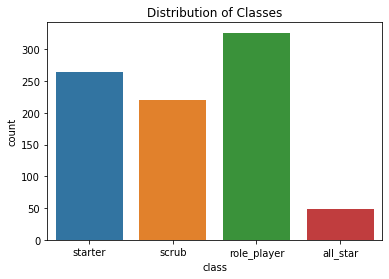

In [2]:
#count plot of classes - imbalanced
sns.countplot(x='class',data=df)
plt.title('Distribution of Classes')

#### 1.3 Process Data for Modeling | Scale, Split into Train and Test

The next step is to transform the data for modeling. For a simple linear regression, the transformation isn't necassary but once more advanced techniques are applied this will be necassary. Therefore it makes sense to simply apply now. The categorical data will go thru a one-hot encoding transformation and the numerical data will be scaled to remove order of magnitude differences in variables

In [3]:
#identify categorical and continuous fields
cont_fields = ['assists_per_40', 'blocks_per_40','free_throw_attempts_per_40','personal_fouls_per_40', 
               'points_per_40','steals_per_40', 'three_point_attempts_per_40','two_point_percentage',
               'three_point_percentage','free_throw_percentage','total_rebounds_per_40', 'turnovers_per_40',
               'two_point_attempts_per_40','height']

cat_fields = ['yrs_played']

response = 'class'

#process data and split into training and test set
Xtrain,Xtest,ytrain,ytest = tts(df,cat_fields,cont_fields,response)

#apply feature selection algorithm
Xtrain, Xtest,cols = feature_selection(Xtrain,ytrain,Xtest,ytest)

#apply smote to oversample underrepresented classes
smote =  SMOTE(sampling_strategy = 'auto',random_state = 42)
Xtrain_re,ytrain = smote.fit_resample(Xtrain,ytrain)
Xtrain = pd.DataFrame(Xtrain_re,columns = Xtrain.columns)

C:\Users\David\Anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\David\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
C:\Users\David\Anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22

Text(0.5, 1.0, 'Resampled Distribution of Classes')

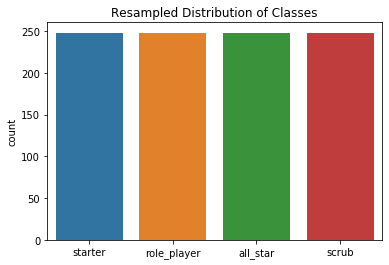

In [4]:
#count plot after SMOTE application
sns.countplot(ytrain)
plt.title('Resampled Distribution of Classes')

### Sample Models: Think Like a Fox, not a Hedgehog

Below are included a few different approaches for a classification model. Logistic Regression is the OG where as Random Forest and XGB each use slight different techniques (tree-based and gradient boosting, respectively). The results below indicate that none of the models are exceptional when it comes to predicting classes. Of course, I think it is better to consider the models based on probablistic outputs instead of hard outputs, making some of the model metrics obsolete. 

For example, consider the results table of the Logistic Regression for a few players in the 2013 NBA Draft. Victor Oladipo and Anthony Bennett are both predicted to be All-Stars within their first 4 years in the league. At face value, this means you could pick either one and feel confident you are getting a good prospect. However, peering at the probabilties tells a slight different story. Oladipo has a 64% chance of being an All Star and and Bennett only a 78%. So that means you would select Bennett first, right? Looking at some of the other probabilties, we can see that Oladipo has a nine percent chance greater than Bennett of being a scrub (aka "Bust"). Even looking at the Role Player probabilities, Bennet has 1% greater chance of being nothing more than a bench player after 4 years. So how valuable are the predicted labels? And who should be picked first? 

Well, context is everything. A NBA GM knows a 1st pick can make or break their job. Landing an All-Star may do nothing more than satisfy a fanciful owner who expects nothing less from the 1st pick, when the reality is that landing a Starter is historically the most likely outcome. Landing a Scrub is a one-way ticket out the door. Therefore, I would seek to minimize the chance of drafting a Scrub or Role Player in order to save my own rear end. Victor Oladipo has a __82%__ of being a Starter or All-Star and Anthony Bennett has a __90%__ chance so I am going with Bennett. A different context may lead to a different choice.

#### 1.4 Logistic Regression

In [5]:
#fit and evaluate a Logistic Regression
model1 = LogisticRegression(random_state=42)
model1.fit(Xtrain,ytrain)
#Hard vote outcome
y_predict = model1.predict(Xtest)
#Soft vote outcome
y_predict_proba = model1.predict_proba(Xtest)
print(metrics.classification_report(ytest, y_predict))

              precision    recall  f1-score   support

    all_star       0.12      0.44      0.19        16
 role_player       0.38      0.29      0.33        78
       scrub       0.51      0.46      0.48        81
     starter       0.35      0.29      0.32        83

    accuracy                           0.35       258
   macro avg       0.34      0.37      0.33       258
weighted avg       0.40      0.35      0.37       258



In [6]:
#Coefficients of each variable by class
pd.DataFrame(model1.coef_,columns=Xtest.columns,index=model1.classes_)

,three_point_attempts_per_40,yrs_played_3,steals_per_40,points_per_40,total_rebounds_per_40,three_point_percentage,yrs_played_2,two_point_percentage,yrs_played_1,assists_per_40,yrs_played_4,free_throw_percentage
all_star,-0.052698,-0.026958,0.285709,0.670760,0.635774,0.276857,-0.049867,0.630737,1.447561,0.675102,-0.747229,0.234851
role_player,0.031818,0.043157,-0.235001,-0.144788,-0.160280,-0.143758,0.445046,-0.205100,-0.254590,-0.171726,0.357913,-0.036355
scrub,-0.129700,-0.431900,-0.082058,-0.416516,-0.488513,-0.095824,-0.433331,-0.117838,-1.310354,-0.417681,0.276278,-0.113545
starter,0.150580,0.415701,0.031350,-0.109456,0.013019,-0.037275,0.038152,-0.307799,0.117383,-0.085695,0.113039,-0.084952


In [7]:
results = pd.concat([
           ytest,pd.DataFrame(y_predict_proba,columns = model1.classes_).set_index(Xtest.index)],axis=1)
results['class_predict'] = y_predict
cols = ['class','class_predict','all_star','starter','role_player']
print('2013 NBA Draft Class Results')
results[results.index.isin(['Anthony Bennett','Victor Oladipo','Kentavious Caldwell-Pope','Trey Burke'])].round(2)

2013 NBA Draft Class Results


,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Anthony Bennett,scrub,0.78,0.08,0.02,0.11,all_star
Victor Oladipo,starter,0.64,0.07,0.11,0.18,all_star
Kentavious Caldwell-Pope,starter,0.12,0.33,0.16,0.39,starter
Trey Burke,starter,0.30,0.31,0.13,0.26,role_player


In [8]:
results[results['class_predict']=='all_star'].sort_values(by='all_star',ascending=False).round(2).head(10)

,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Michael Beasley,starter,0.98,0.00,0.00,0.01,all_star
Kyrie Irving,all_star,0.96,0.01,0.00,0.03,all_star
Kevin Love,all_star,0.94,0.02,0.00,0.03,all_star
Larry Stewart,starter,0.92,0.03,0.02,0.03,all_star
DeMarcus Cousins,starter,0.91,0.03,0.01,0.05,all_star
Stephen Curry,starter,0.91,0.02,0.00,0.07,all_star
Rodney Stuckey,starter,0.87,0.05,0.01,0.07,all_star
Glenn Robinson,starter,0.84,0.04,0.01,0.11,all_star
Isaiah Rider,starter,0.83,0.08,0.01,0.07,all_star


#### 1.5 Random Forest

In [9]:
#fit and evaluate a Random Forest classifier
model2 = RandomForestClassifier(random_state = 42)
model2.fit(Xtrain,ytrain)
y_predict = model2.predict(Xtest)
y_predict_proba = model2.predict_proba(Xtest)
print(metrics.classification_report(ytest, y_predict))

              precision    recall  f1-score   support

    all_star       0.17      0.25      0.20        16
 role_player       0.37      0.53      0.43        78
       scrub       0.46      0.27      0.34        81
     starter       0.46      0.41      0.43        83

    accuracy                           0.39       258
   macro avg       0.36      0.36      0.35       258
weighted avg       0.41      0.39      0.39       258



In [10]:
pd.DataFrame({'Features':Xtest.columns,'Feature Importance':model2.feature_importances_}).sort_values(by='Feature Importance',ascending=False)

,Features,Feature Importance
3,points_per_40,0.126744
7,two_point_percentage,0.117707
2,steals_per_40,0.117216
4,total_rebounds_per_40,0.114316
11,free_throw_percentage,0.106351
9,assists_per_40,0.101932
0,three_point_attempts_per_40,0.095853
5,three_point_percentage,0.091909
8,yrs_played_1,0.050805
10,yrs_played_4,0.036836


In [11]:
results = pd.concat([
           ytest,pd.DataFrame(y_predict_proba,columns = model2.classes_).set_index(Xtest.index)],axis=1)
results['class_predict'] = y_predict
cols = ['class','class_predict','all_star','starter','role_player']
results[results['class_predict']=='all_star'].sort_values(by='all_star',ascending=False).round(2).head(10)

,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Michael Beasley,starter,0.55,0.23,0.10,0.12,all_star
Rodney Rogers,starter,0.55,0.10,0.03,0.32,all_star
Richard Hamilton,starter,0.52,0.19,0.04,0.25,all_star
Kevin Love,all_star,0.51,0.28,0.07,0.14,all_star
Adam Keefe,role_player,0.51,0.17,0.05,0.27,all_star
Isaiah Rider,starter,0.50,0.16,0.09,0.25,all_star
Derek Anderson,starter,0.46,0.34,0.06,0.14,all_star
DerMarr Johnson,role_player,0.44,0.22,0.13,0.21,all_star
Kemba Walker,starter,0.42,0.27,0.07,0.24,all_star


#### 1.6 XGB Classifier

In [12]:
#fit and evalutea an XGB Classifier
model3 = XGBClassifier(random_state = 42)
model3.fit(Xtrain,ytrain)
y_predict = model3.predict(Xtest)
y_predict_proba = model3.predict_proba(Xtest)
print(metrics.classification_report(ytest, y_predict))

              precision    recall  f1-score   support

    all_star       0.13      0.25      0.17        16
 role_player       0.34      0.36      0.35        78
       scrub       0.52      0.46      0.49        81
     starter       0.36      0.33      0.34        83

    accuracy                           0.37       258
   macro avg       0.34      0.35      0.34       258
weighted avg       0.39      0.37      0.38       258



In [13]:
pd.DataFrame({'Features':Xtest.columns,'Feature Importance':model3.feature_importances_}).sort_values(by='Feature Importance',ascending=False)

,Features,Feature Importance
8,yrs_played_1,0.208786
3,points_per_40,0.104123
10,yrs_played_4,0.099246
1,yrs_played_3,0.080473
4,total_rebounds_per_40,0.075467
7,two_point_percentage,0.068806
9,assists_per_40,0.068758
2,steals_per_40,0.066692
6,yrs_played_2,0.064509
0,three_point_attempts_per_40,0.060935


In [14]:
results = pd.concat([
           ytest,pd.DataFrame(y_predict_proba,columns = model3.classes_).set_index(Xtest.index)],axis=1)
results['class_predict'] = y_predict
cols = ['class','class_predict','all_star','starter','role_player']
results[results['class_predict']=='all_star'].sort_values(by='all_star',ascending=False).round(2).head(10)

,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Zach Randolph,starter,0.72,0.16,0.04,0.08,all_star
Isaiah Rider,starter,0.71,0.13,0.04,0.12,all_star
Adam Keefe,role_player,0.69,0.21,0.04,0.06,all_star
Derek Anderson,starter,0.67,0.12,0.03,0.18,all_star
Michael Beasley,starter,0.65,0.23,0.02,0.10,all_star
Rodney Rogers,starter,0.64,0.14,0.06,0.17,all_star
Rodney Stuckey,starter,0.64,0.17,0.04,0.15,all_star
Kevin Love,all_star,0.63,0.27,0.04,0.06,all_star
Joe Smith,starter,0.62,0.16,0.07,0.14,all_star


#### Ensemble Classifiers

Since none of the individual models are a slam dunk, it makes sense to consider using an ensemble classifier. These classifiers will take the results of each model and aggregate their outputs together. As the previous results indicate, each model favors different players based on their inherent algorithm. One way to to tip-toe around this uncertainty is to take each model and essentially aggregate the results together. What this will do is normalize the results and create a model that will be less likely to overfit. Think of this like the "Ask the Audience" option on Who Wants to Be A Millionaire. By polling multiple people you are more likely to get a correct answer instead of "Phoning a Friend" who may or may not be an expert on the question. 

There are two types of ensemble classifiers - Voting and Stacking. Voting takes the results of each model and generates a consensus prediction while a Stacking Classifier will run each model and pick and choose the best pattern detection of each model. I want to decided which one one to use. The classic classification metrics indicate that the Voting Classifier is slightly better with a weighted accuracy of 44% compared to 41% but I want to approach this from a more practical approach. 

Suppose I am a GM making a draft pick. If the model predicts a player to be an All-Star and he turns into a Starter, I can live with that; so can the team owner. But what if an projected All-Star turns into a Role Player or Scrub? That's no bueno. Therefore I want to know not only which model predicts the right class most often, but which model has the fewest "swing-and-misses": where a player is actually two or more classes removed from the prediction. So I have added a simple mapping function to assign each class a value from 1 to 4 and then quantify the difference between classes. The results below show that the Voting Classifier had 5 results where the difference between predict and actual class was All-Star to Scrub or vice-a-versa. The Stacking Classifier managed to have no differences of 3 though it had fewer accurate predictions (differences of 0). Because my intent is to minimize wide variances, I will use the Stacking Classifier in the final model. 

#### 1.7 Voting Classifier

In [15]:
#embed models in CLassifier and fit
voting_model = VotingClassifier(
    estimators=[("log",model1),("rf",model2),("xgb",model3)],
    voting="soft")

voting_model.fit(Xtrain,ytrain)
voting_model_predict = voting_model.predict(Xtest)
voting_model_predict_proba = voting_model.predict_proba(Xtest)
print(metrics.classification_report(ytest, voting_model_predict))

              precision    recall  f1-score   support

    all_star       0.10      0.25      0.15        16
 role_player       0.40      0.41      0.41        78
       scrub       0.53      0.42      0.47        81
     starter       0.45      0.41      0.43        83

    accuracy                           0.40       258
   macro avg       0.37      0.37      0.36       258
weighted avg       0.44      0.40      0.42       258



In [26]:
voting_results = pd.concat([
           ytest,pd.DataFrame(voting_model_predict_proba,columns = voting_model.classes_).set_index(Xtest.index)],axis=1)
voting_results['class_predict'] = voting_model_predict
cols = ['class','class_predict','all_star','starter','role_player']
voting_results[voting_results['class_predict']=='all_star'].sort_values(by='all_star',ascending=False).round(2).head(10)

,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Michael Beasley,starter,0.73,0.15,0.04,0.08,all_star
Kevin Love,all_star,0.69,0.19,0.04,0.08,all_star
Isaiah Rider,starter,0.68,0.12,0.05,0.15,all_star
Adam Keefe,role_player,0.64,0.16,0.05,0.15,all_star
Rodney Stuckey,starter,0.62,0.14,0.09,0.15,all_star
Zach Randolph,starter,0.62,0.22,0.03,0.13,all_star
Derek Anderson,starter,0.61,0.18,0.05,0.16,all_star
DeMarcus Cousins,starter,0.60,0.22,0.05,0.13,all_star
Rodney Rogers,starter,0.60,0.11,0.06,0.23,all_star


#### 1.8 Stacked Classifier

In [19]:
#embed models in Classifier and use Logistic Regression as Final Estimator
stacking_model = StackingClassifier(
    estimators=[("log",model1),("rf",model2),("xgb",model3)],final_estimator = LogisticRegression())

stacking_model.fit(Xtrain,ytrain)
stacking_model_predict = stacking_model.predict(Xtest)
stacking_model_predict_proba = stacking_model.predict_proba(Xtest)
print(metrics.classification_report(ytest, stacking_model_predict))

              precision    recall  f1-score   support

    all_star       0.15      0.12      0.14        16
 role_player       0.35      0.58      0.44        78
       scrub       0.53      0.25      0.34        81
     starter       0.41      0.39      0.40        83

    accuracy                           0.38       258
   macro avg       0.36      0.33      0.33       258
weighted avg       0.41      0.38      0.37       258



In [31]:
stacking_results = pd.concat([
           ytest,pd.DataFrame(stacking_model_predict_proba,columns = stacking_model.classes_).set_index(Xtest.index)],axis=1)
stacking_results['class_predict'] = stacking_model_predict
cols = ['class','class_predict','all_star','starter','role_player']
stacking_results[stacking_results['class_predict']=='all_star'].sort_values(by='all_star',ascending=False).round(2).head(10)

,class,all_star,role_player,scrub,starter,class_predict
name,,,,,,
Richard Hamilton,starter,0.65,0.12,0.06,0.17,all_star
Rodney Rogers,starter,0.62,0.10,0.04,0.24,all_star
Michael Beasley,starter,0.57,0.18,0.09,0.17,all_star
Adam Keefe,role_player,0.56,0.13,0.05,0.26,all_star
Isaiah Rider,starter,0.52,0.16,0.07,0.26,all_star
DerMarr Johnson,role_player,0.51,0.16,0.13,0.19,all_star
Kevin Love,all_star,0.48,0.22,0.08,0.22,all_star
Derek Anderson,starter,0.46,0.24,0.09,0.20,all_star
Kemba Walker,starter,0.40,0.24,0.11,0.25,all_star


#### Measuring Success: Voting Classifier versus Stacking Classifier

In [37]:
#quantify each class 
def class_predict_map(v):
    v = str(v)
    if v == 'all_star':
        return(4)
    elif v == 'starter':
        return(3)
    elif v == 'role_player':
        return(2)
    else:
        return(1)

    
#calcuate the the difference between actual and predicted classes
vote_mod_diff = abs(voting_results['class_predict'].map(class_predict_map) - voting_results['class'].map(class_predict_map))
print('Voting Model Predict vs. Actual Diff')
print(vote_mod_diff.value_counts())
print('---------------------------')
stack_mod_diff = abs(stacking_results['class_predict'].map(class_predict_map) - stacking_results['class'].map(class_predict_map))
print('Stacking Model Predict vs. Actual Diff')
print(stack_mod_diff.value_counts())

Voting Model Predict vs. Actual Diff
1    114
0    104
2     35
3      5
dtype: int64
---------------------------
Stacking Model Predict vs. Actual Diff
1    119
0     99
2     40
dtype: int64
